# U-Net in Tensorflow

## 1 Import Dependencies

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams["savefig.dpi"] = 300
import imageio.v2 as imageio
import json

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
# Copy Data from drive to colab
!cp -r '/content/drive/MyDrive/cityscapes' '/content/cityscapes'

## 2 Data Preperation

### 2.1 Extraction

In [2]:
# Citiscapes Path
cityscapes_path = '/Users/kan/Desktop/01_learn_pytorch/cityscapes'
# cityscapes_path = '/content/drive/MyDrive/cityscapes'
# cityscapes_path = '/content/cityscapes'

# train_val img
# Define the base directories
train_val_img_dir = cityscapes_path + '/leftImg8bit/train'
train_val_img_dir2 = cityscapes_path + '/leftImg8bit/val/lindau'

# Use glob to get all .png files in each base directory and its subdirectories
train_val_img_paths = glob.glob(os.path.join(train_val_img_dir, '**/*.png'), recursive=True)
train_val_img_paths2 = glob.glob(os.path.join(train_val_img_dir2, '**/*.png'), recursive=True)

# Combine the two lists
train_val_img_paths = train_val_img_paths + train_val_img_paths2
train_val_img_paths.sort()

# train_val mask
# Define the base directories
train_val_mask_dir = cityscapes_path + '/gtFine/train'
train_val_mask_dir2 = cityscapes_path + '/gtFine/val/lindau'

# Use glob to get all .png files in each base directory and its subdirectories
train_val_mask_paths = glob.glob(os.path.join(train_val_mask_dir, '**/*labelIds.png'), recursive=True)
train_val_mask_paths2 = glob.glob(os.path.join(train_val_mask_dir2, '**/*labelIds.png'), recursive=True)

# Combine the two lists
train_val_mask_paths = train_val_mask_paths + train_val_mask_paths2
train_val_mask_paths.sort()

# test img
# Define the base directories
test_img_dir = cityscapes_path + '/leftImg8bit/val/frankfurt'
test_img_dir2 = cityscapes_path + '/leftImg8bit/val/munster'

# Use glob to get all .png files in each base directory and its subdirectories
test_img_paths = glob.glob(os.path.join(test_img_dir, '**/*.png'), recursive=True)
test_img_paths2 = glob.glob(os.path.join(test_img_dir2, '**/*.png'), recursive=True)

# Combine the two lists
test_img_paths = test_img_paths + test_img_paths2
test_img_paths.sort()

# test mask
# Define the base directories
test_mask_dir = cityscapes_path + '/gtFine/val/frankfurt'
test_mask_dir2 = cityscapes_path + '/gtFine/val/munster'

# Use glob to get all .png files in each base directory and its subdirectories
test_mask_paths = glob.glob(os.path.join(test_mask_dir, '**/*labelIds.png'), recursive=True)
test_mask_paths2 = glob.glob(os.path.join(test_mask_dir2, '**/*labelIds.png'), recursive=True)

# Combine the two lists
test_mask_paths = test_mask_paths + test_mask_paths2
test_mask_paths.sort()


In [3]:
# Split the image paths to have 80% for train and 20% for val
train_img_paths, val_img_paths = train_test_split(train_val_img_paths, test_size=0.2, random_state=42)

# Split the mask paths
train_mask_paths, val_mask_paths = train_test_split(train_val_mask_paths, test_size=0.2, random_state=42)

print(f'number of train_img: {len(train_img_paths)}')
print(f'number of train_mask: {len(train_mask_paths)}')
print(f'number of val_img: {len(val_img_paths)}')
print(f'number of val_mask: {len(val_mask_paths)}')
print(f'number of test_img: {len(test_img_paths)}')
print(f'number of test_mask: {len(test_mask_paths)}')

number of train_img: 2427
number of train_mask: 2427
number of val_img: 607
number of val_mask: 607
number of test_img: 441
number of test_mask: 441


### 2.2 Class Management

In [4]:
class_names = ['void', 'road', 'building', 'vegetation', 'car', 'sidewalk', 'sky', 'pole', 'person', 'terrain']

class_colors = [
    (0, 0, 0), # 'void'
    (128, 64, 128),  # 'road'
    (70, 70, 70),  # 'building'
    (107, 142, 35),  # 'vegetation'
    (0, 0, 142),  # 'car'
    (244, 35, 232),  # 'sidewalk'
    (70, 130, 180),  # 'sky'
    (153, 153, 153),  # 'pole'
    (220, 20, 60),  # 'person'
    (152, 251, 152),  # 'terrain'
]

# look-up table for class mapping
lut = [0, 0, 0, 0, 0, 0,
       0, 1, 5, 0, 0,
       2, 0, 0, 0, 0,
       0, 7, 0, 0, 0,
       3, 9, 6, 8, 0,
       4, 0, 0, 0, 0,
       0, 0, 0, 0]

n_classes = 10

In [5]:
# function to display image
def display_pred(display_list):
    plt.figure(figsize=(20, 20))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# function to create mask
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    color_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))  # initialize the color mask
    for i in range(len(class_colors)):
        color_mask[pred_mask == i] = class_colors[i]  # apply the color mapping
    return color_mask

# function to map mask color
def map_mask_color(mask):
    mask = tf.squeeze(mask, axis=-1).numpy()  # remove the last dimension and convert to numpy array
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)  # initialize the color mask
    for i in range(len(class_colors)):
        color_mask[mask == i] = class_colors[i]  # apply the color mapping
    return color_mask

Show a sample before transformation

Text(0.5, 1.0, 'True Mask')

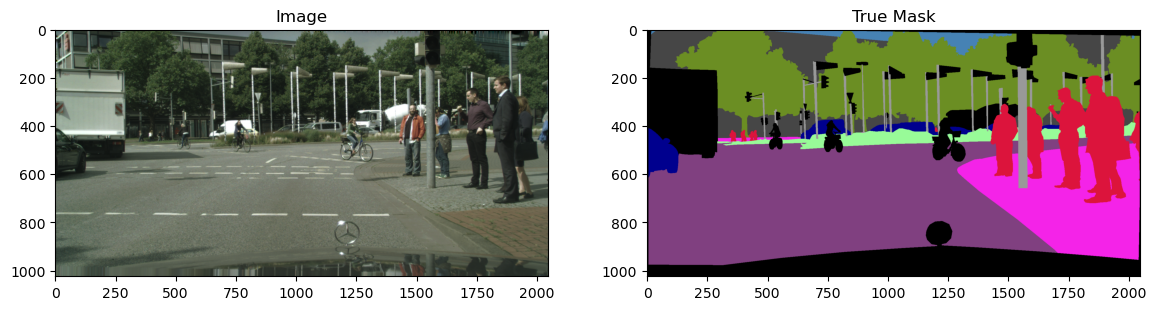

In [19]:
n = 3
img = imageio.imread(train_img_paths[n])
mask = imageio.imread(train_mask_paths[n])

def mask_remap(mask, lut=lut):
  # Remap values in the mask
	lut_np = np.array(lut)  # Convert your lut to a numpy array
	mask_remap = lut_np[mask]
	return apply_color_map(mask_remap)

def apply_color_map(mask, color_map=class_colors):
    # Create an empty RGB image
    rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    # For each class, apply the corresponding color
    for class_index, color in enumerate(color_map):
        rgb_mask[mask == class_index] = color
    return rgb_mask

# remap the mask
mask = mask_remap(mask)

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('True Mask')

### 2.3 Transformation

In [6]:
img_height = 256
img_width = 512
batch_size = 16
buffer_size = 256
autotune = tf.data.AUTOTUNE

# Data augmentation
def data_augment(image, mask):
    image = tf.image.random_flip_left_right(image, seed=7)
    mask = tf.image.random_flip_left_right(mask, seed=7)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    return image, mask

# Process the image and mask
def process_path(img_path, mask_path):
    # load the raw data from the file
    img = tf.io.read_file(img_path)
    mask = tf.io.read_file(mask_path)

    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    mask = tf.image.decode_png(mask, channels=1)

    # resize the image to the desired size.
    img = tf.image.resize(img, [img_height, img_width], method='nearest')
    mask = tf.image.resize(mask, [img_height, img_width], method='nearest')
    
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # remap mask
    mask = tf.gather(lut, tf.cast(mask, tf.int32))

    return img, mask

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_img_paths, val_mask_paths))
test_dataset = tf.data.Dataset.from_tensor_slices((test_img_paths, test_mask_paths))

# Map the processing function to datasets
train_dataset = train_dataset.map(process_path, num_parallel_calls=autotune)
train_dataset = train_dataset.map(data_augment, num_parallel_calls=autotune)
val_dataset = val_dataset.map(process_path, num_parallel_calls=autotune)
test_dataset = test_dataset.map(process_path, num_parallel_calls=autotune)

# Shuffle and batch
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(autotune)
val_dataset = val_dataset.shuffle(buffer_size).batch(batch_size).prefetch(autotune)
test_dataset = test_dataset.shuffle(buffer_size).batch(batch_size).prefetch(autotune)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



Show the processed images

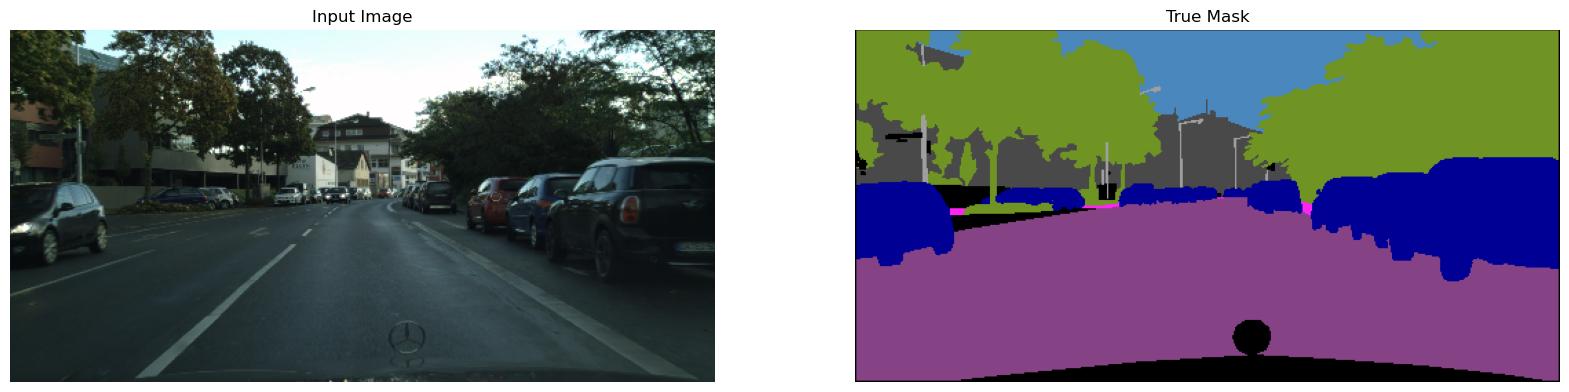

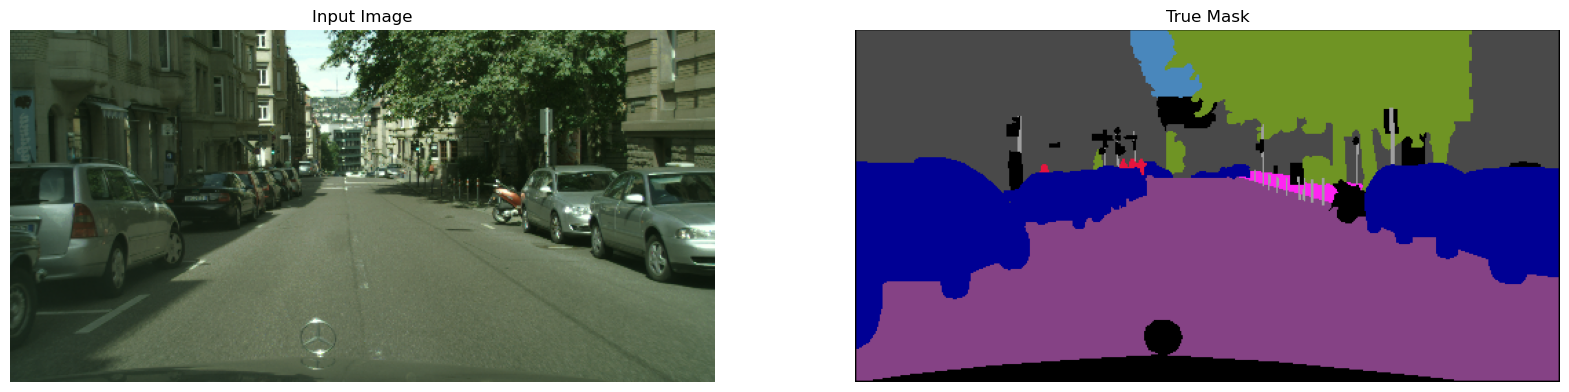

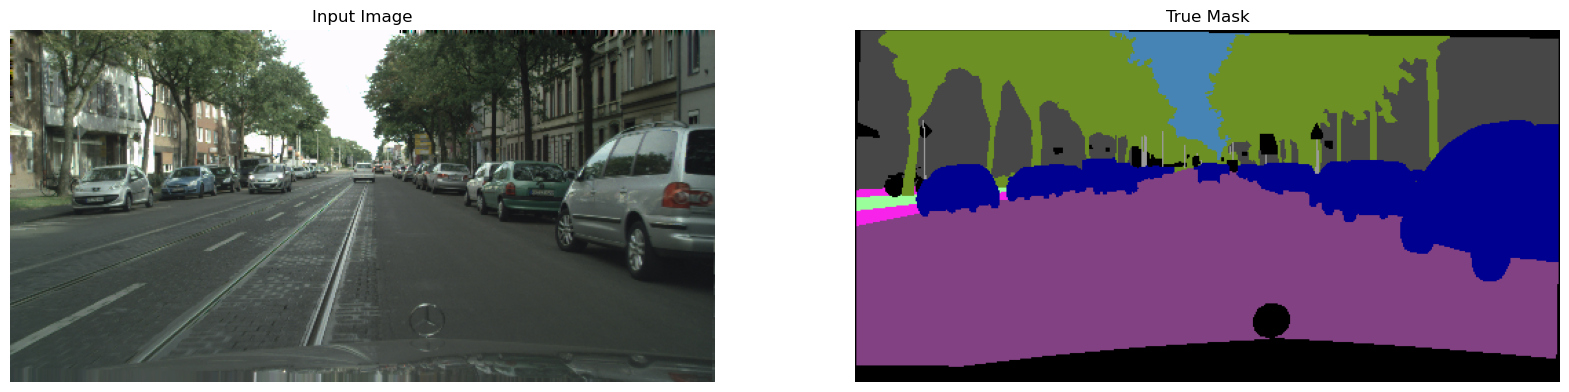

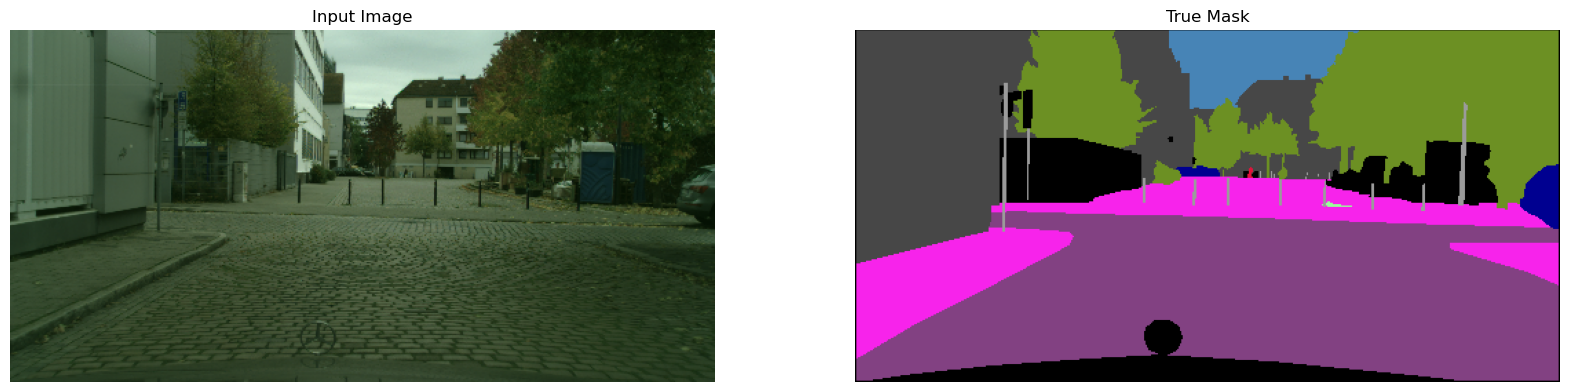

In [9]:
def show_img(dataset=None, num=1):
    if dataset:
        for i, (image, mask) in enumerate(dataset.take(num)):
            display_pred([image[i], map_mask_color(mask[i])])  # map the color of the ground truth mask

show_img(train_dataset, 4)

## 3 Model Architecture

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

The architecture diagram is taken from https://www.coursera.org/learn/convolutional-neural-networks/.

The model adapts from the above diagram by inserting dropout layers to prevent overfiting and using he_normal as kernel_initializers.

In [38]:
# adapt from the above diagram by inserting dropout layers to prevent overfiting
# number of starting filters
n_filters = 64
# number of layers in the encoder/decoder
n_layers = 4

def unet(input_size=(img_height, img_width, 3), n_filters=n_filters, n_layers=n_layers, n_classes=n_classes):
	
	# Input
	x = tf.keras.layers.Input(shape=input_size)
	inputs = x

	# Encoder
	layers = []
	for i in range(n_layers):
		x = tf.keras.layers.Conv2D(n_filters, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
		x = tf.keras.layers.Conv2D(n_filters, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
		layers.append(x)
		x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
		x = tf.keras.layers.Dropout(0.3)(x)

		n_filters = n_filters * 2

	# Bottle neck
	x = tf.keras.layers.Conv2D(n_filters, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
	x = tf.keras.layers.Conv2D(n_filters, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)


	# Decoder
	for i in range(n_layers):
		n_filters = n_filters // 2
		x = tf.keras.layers.Conv2DTranspose(n_filters, 3, strides=(2,2), padding='same')(x)
		x = tf.keras.layers.concatenate([x, layers[-(i+1)]])
		x = tf.keras.layers.Dropout(0.3)(x)
		x = tf.keras.layers.Conv2D(n_filters, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
		x = tf.keras.layers.Conv2D(n_filters, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
	
	# output
	outputs = tf.keras.layers.Conv2D(n_classes, 1, activation='softmax', padding='same', kernel_initializer='he_normal')(x)
	
	model = tf.keras.Model(inputs=inputs, outputs=outputs)
	return model

model = unet()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 512, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 256, 512, 64  36928       ['conv2d_57[0][0]']              
                                )                                                           

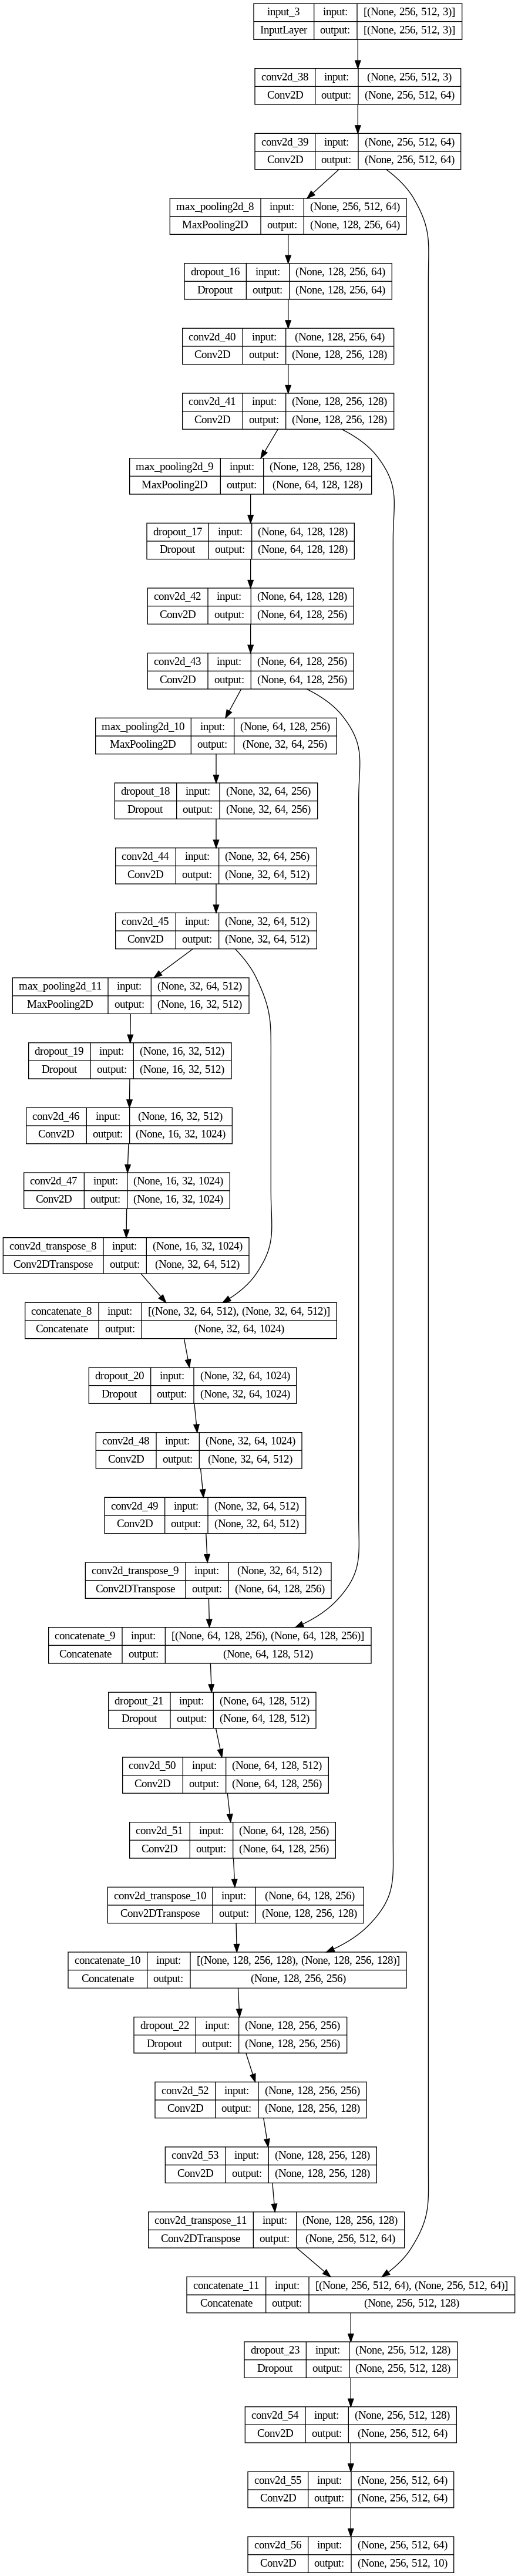

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 4 Training

In [22]:
epochs = 200
save_path = '/content/drive/MyDrive/developing_model/unet_3_save/'
# save_path = 'unet_3_save/'

# load checkpoint
# model.load_weights(save_path+'checkpoint.h5')

# add class weights to balance the classes
def add_sample_weights(image, label):
  class_weights = tf.constant([1.0, 1.0, 1.0, 1.0, 1.0,
                               1.8, 1.0, 2.5, 2.0, 2.3])
  class_weights = class_weights/tf.reduce_sum(class_weights)
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

def callbacks():
        checkpointer = tf.keras.callbacks.ModelCheckpoint(
                filepath=save_path + 'checkpoint.h5', 
                save_best_only=True, 
                save_weights_only=True, 
                verbose=1)
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', 
                factor=0.2,
                verbose=1,
                patience=3)
        early_stop = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                verbose=1,
                restore_best_weights=True)
        callbacks = [checkpointer, reduce_lr, early_stop]
        return callbacks

model.compile(optimizer='adam',
		loss='sparse_categorical_crossentropy',
		metrics=['accuracy'])

model_history = model.fit(train_dataset.map(add_sample_weights), 
          epochs=epochs, 
          validation_data=val_dataset,
          callbacks = callbacks()
          )

Epoch 1/200
152/152 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.4375
Epoch 1: val_loss improved from inf to 1.28944, saving model to /content/drive/MyDrive/developing_model/unet_3_save/checkpoint.h5
152/152 [==============================] - 143s 818ms/step - loss: 0.1293 - accuracy: 0.4375 - val_loss: 1.2894 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 2/200
152/152 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.5797
Epoch 2: val_loss improved from 1.28944 to 0.96204, saving model to /content/drive/MyDrive/developing_model/unet_3_save/checkpoint.h5
152/152 [==============================] - 136s 837ms/step - loss: 0.0994 - accuracy: 0.5797 - val_loss: 0.9620 - val_accuracy: 0.6663 - lr: 0.0010
Epoch 3/200
152/152 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.6725
Epoch 3: val_loss improved from 0.96204 to 0.85287, saving model to /content/drive/MyDrive/developing_model/unet_3_save/checkpoint.h5
152/152 [======

Plot loss and accuracy from the training

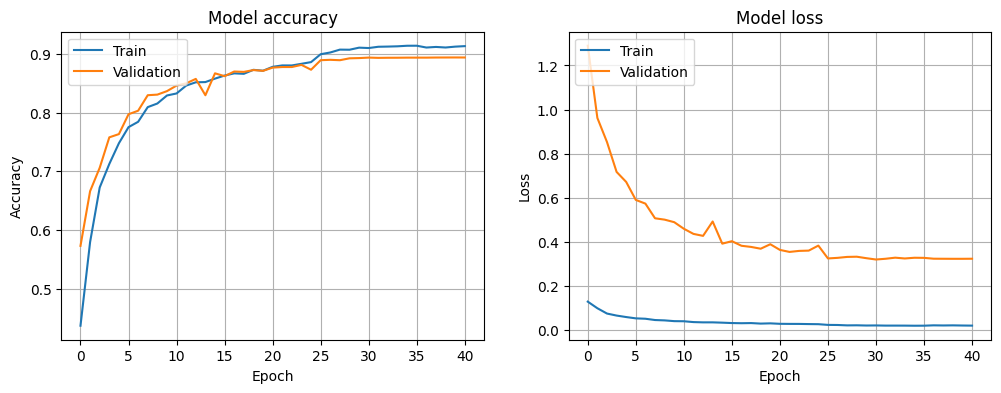

In [24]:
def plot_model_history(model_history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(model_history['accuracy'])
    plt.plot(model_history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(model_history['loss'])
    plt.plot(model_history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)

    plt.show()
    
plot_model_history(model_history.history)

Save/Load Model

In [ ]:
save_path = 'unet_3_save/'

# Save model
# model.save(save_path + "model.h5")

# Load model
model = tf.keras.models.load_model(save_path + "model.h5")

# Save model_history
# history_dict = {k: [float(val) for val in v] for k, v in model_history.history.items()}
# json.dump(history_dict, open(save_path + 'model_history_saved.json', 'w'))

# Load model_history
# model_history_saved = json.load(open(save_path + 'model_history_saved.json', 'r'))

## 5 Evaluation on Test Dataset

IoU

In [24]:
# Initialize the MeanIoU metric
iou_metric = tf.keras.metrics.MeanIoU(num_classes=n_classes)

# Iterate over the batches of the test dataset
for images, labels in test_dataset:
    # Generate predictions for the images
    predictions = model.predict(images, verbose=0)
    # Convert predictions to label indices
    predictions = tf.argmax(predictions, axis=-1)
    # Update the IoU metric
    iou_metric.update_state(y_true=labels, y_pred=predictions)

# Get the result of the MeanIoU metric
mean_iou = iou_metric.result().numpy()

# Get the confusion matrix
confusion_matrix = iou_metric.get_weights()[0]

# Calculate IoU for each class
ious = np.diag(confusion_matrix) / (np.sum(confusion_matrix, axis=0) + np.sum(confusion_matrix, axis=1) - np.diag(confusion_matrix))
ious = np.nan_to_num(ious)  # replace nan with zero

# Print the IoU for each class
for i, class_name in enumerate(class_names):
    print(f"{i+1} IoU for {class_name}: {ious[i]}")

print(f"Mean IoU: {mean_iou}")

1 IoU for void: 0.6663756370544434
2 IoU for road: 0.9419246315956116
3 IoU for building: 0.8041686415672302
4 IoU for vegetation: 0.8583233952522278
5 IoU for car: 0.861713171005249
6 IoU for sidewalk: 0.6684961318969727
7 IoU for sky: 0.8970048427581787
8 IoU for pole: 0.40145307779312134
9 IoU for person: 0.530326247215271
10 IoU for terrain: 0.43756261467933655
Mean IoU: 0.706734836101532


Plot the IoUs

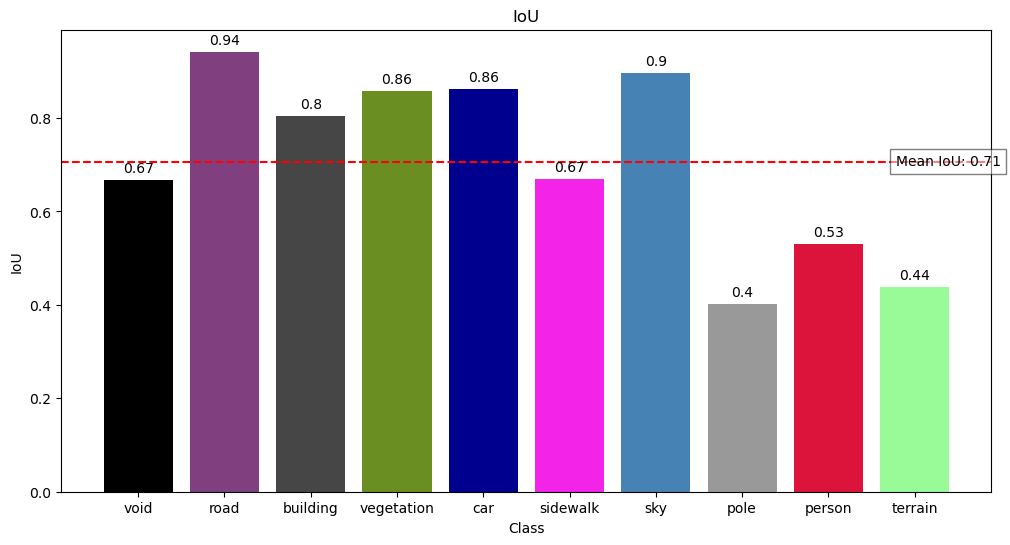

In [26]:
# Create an array of colors from the colormap
colors = [(r / 255, g / 255, b / 255) for r, g, b in class_colors]

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, ious, color=colors)
plt.axhline(y=mean_iou, color='r', linestyle='--')

# Show the exact number on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval,2), ha='center', va='bottom')

plt.text(len(class_names), mean_iou, 'Mean IoU: {:.2f}'.format(mean_iou), va='center', ha="right", bbox=dict(facecolor="w",alpha=0.5))
plt.xlabel('Class')
plt.ylabel('IoU')
plt.title('IoU')
plt.show()

## 6 Prediction

### 6.1 Prediction on Test Dataset

1/1 [==============================] - 0s 474ms/step


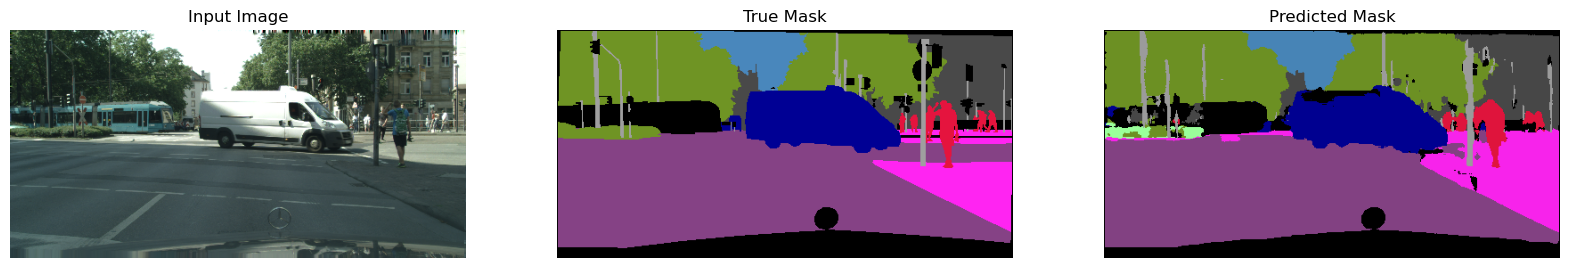

1/1 [==============================] - 0s 48ms/step


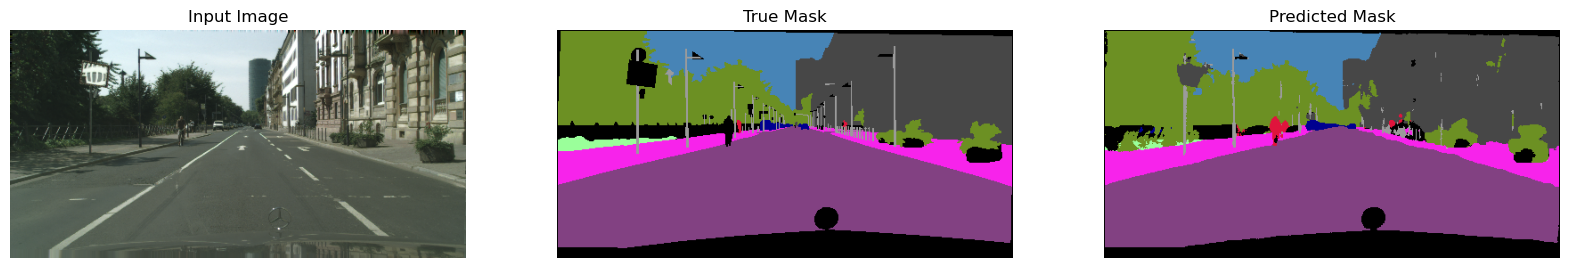

1/1 [==============================] - 0s 31ms/step


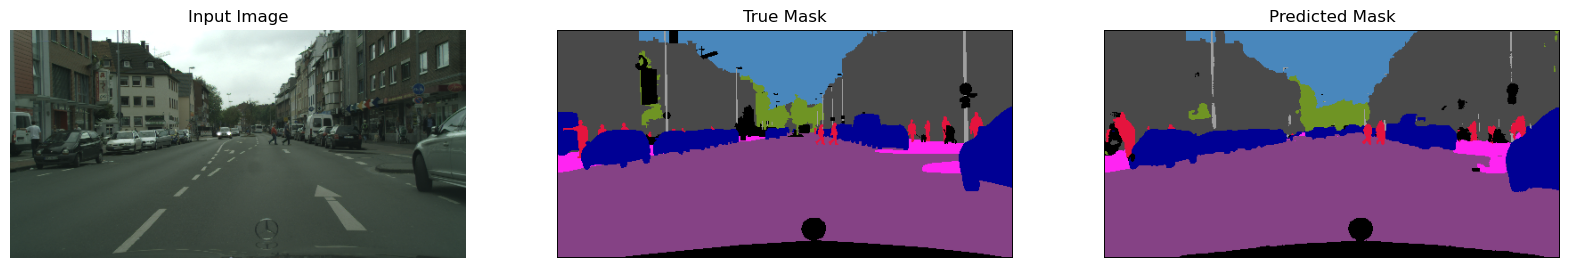

1/1 [==============================] - 0s 52ms/step


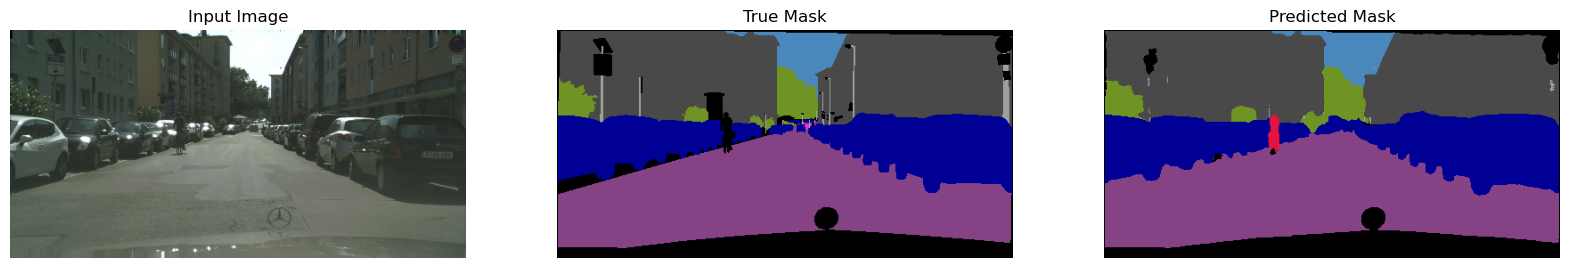

1/1 [==============================] - 0s 33ms/step


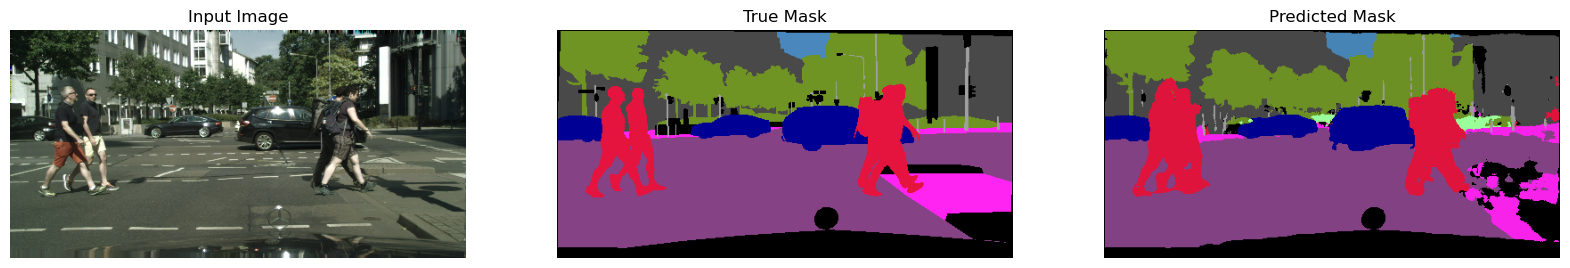

1/1 [==============================] - 0s 26ms/step


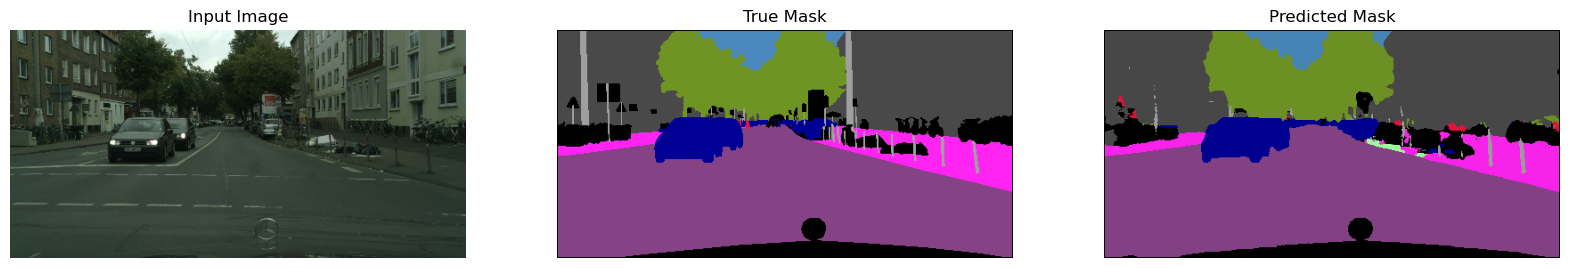

1/1 [==============================] - 0s 45ms/step


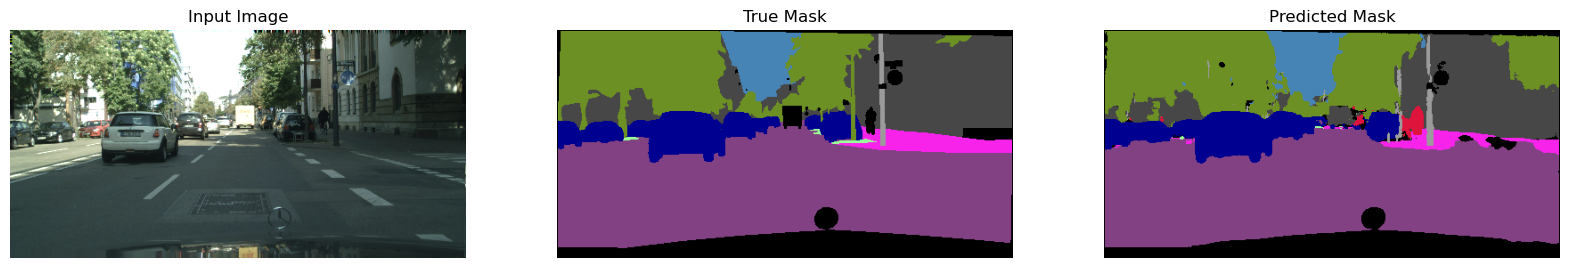

1/1 [==============================] - 0s 47ms/step


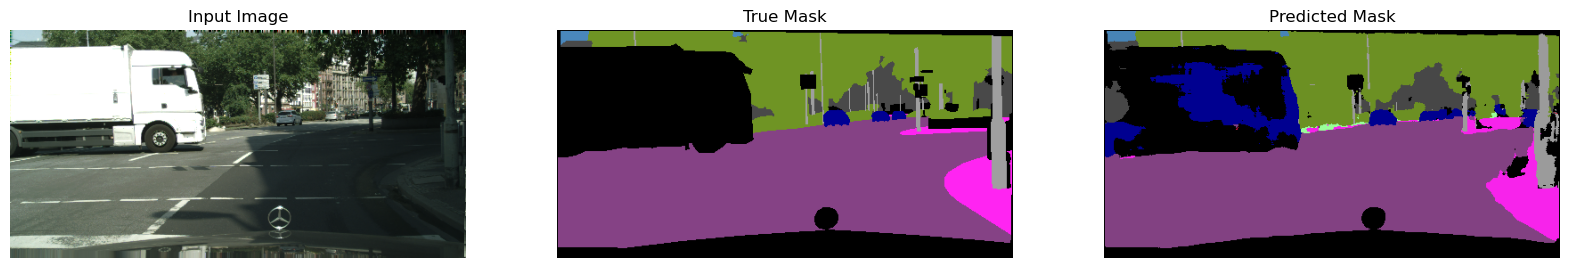

1/1 [==============================] - 0s 16ms/step


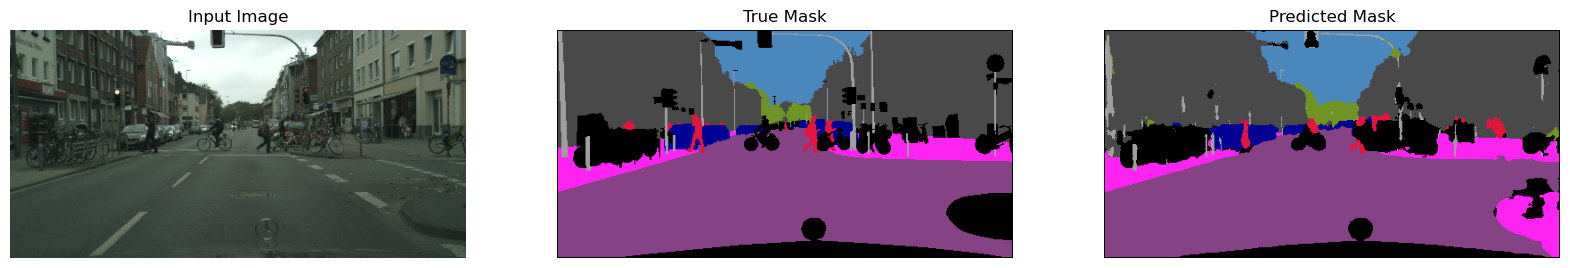

1/1 [==============================] - 0s 16ms/step


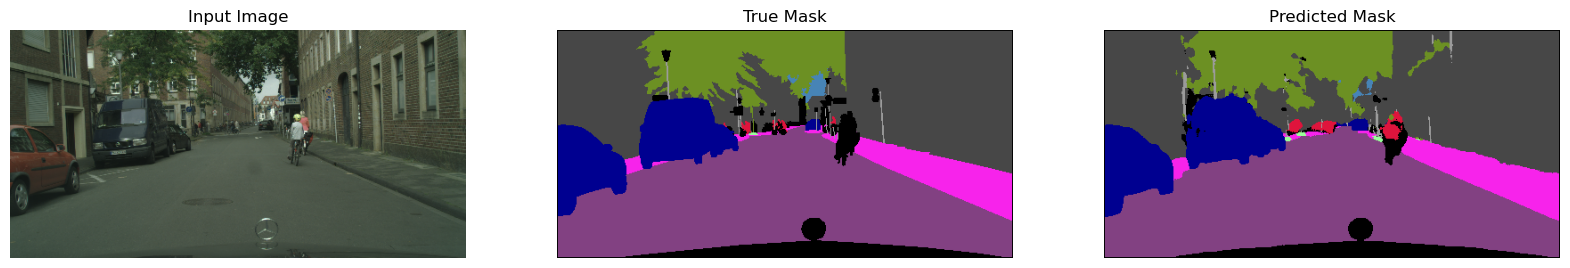

1/1 [==============================] - 0s 17ms/step


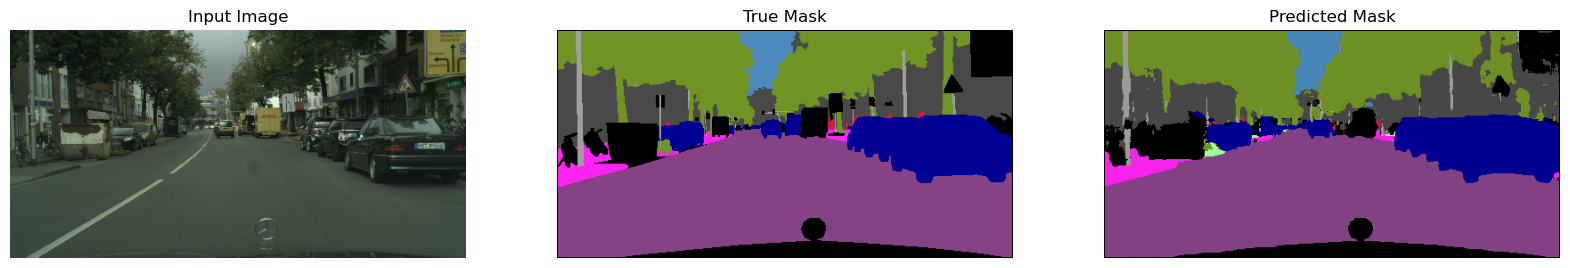

1/1 [==============================] - 0s 17ms/step


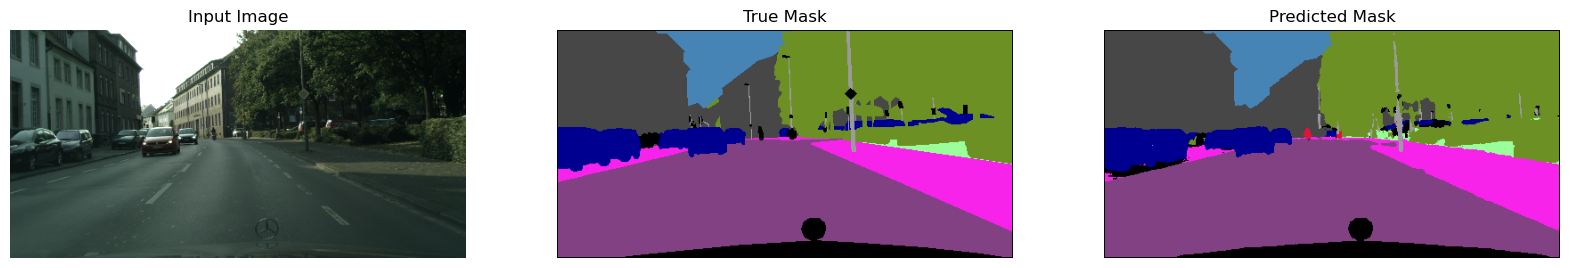

1/1 [==============================] - 0s 17ms/step


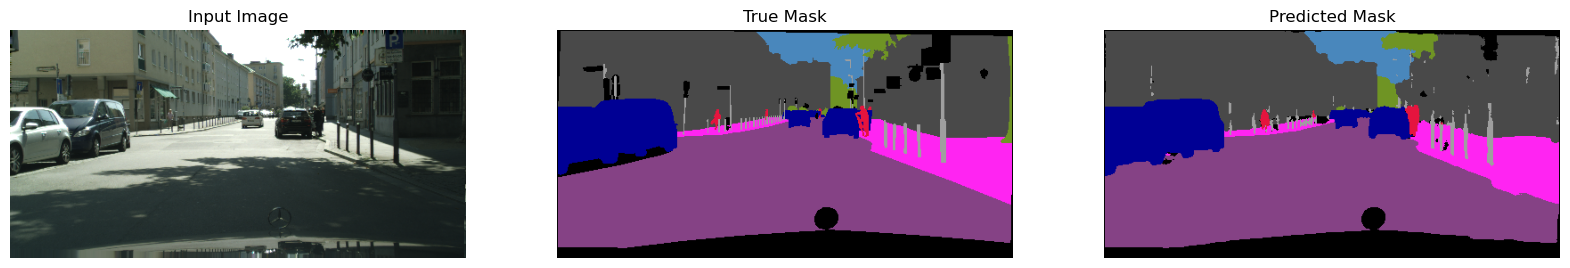

1/1 [==============================] - 0s 19ms/step


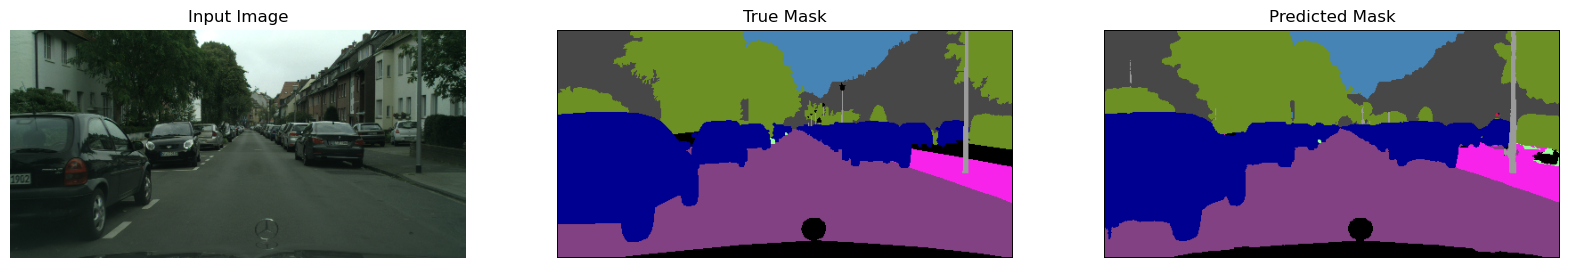

1/1 [==============================] - 0s 15ms/step


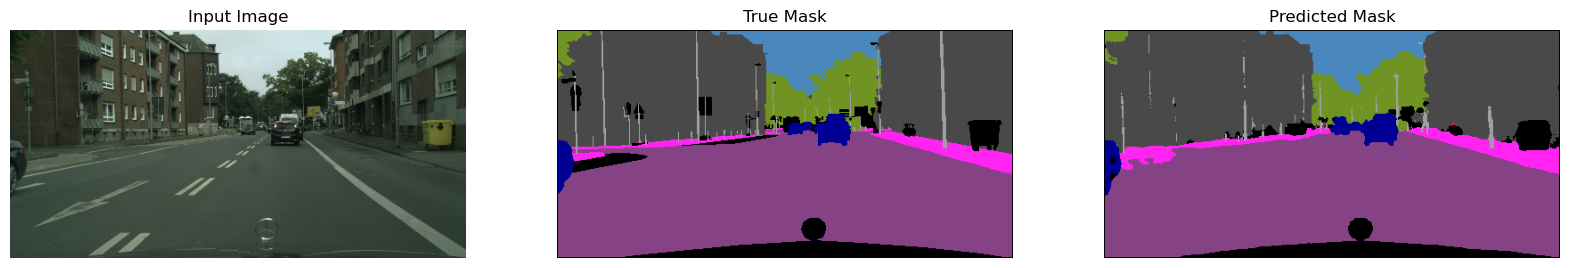

1/1 [==============================] - 0s 16ms/step


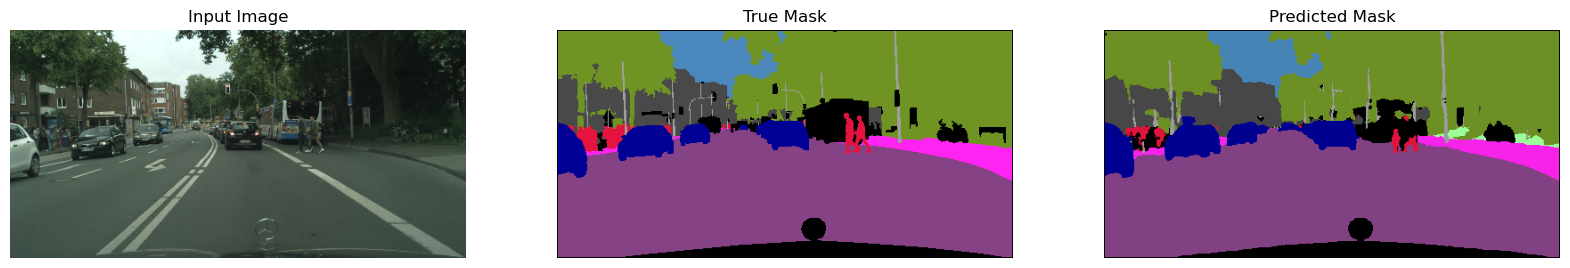

In [22]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for i, (image, mask) in enumerate(dataset.take(num)):
            pred_mask = model.predict(tf.expand_dims(image[i], axis=0))  # model.predict expects a batch, so expand_dims
            display_pred([image[i], map_mask_color(mask[i]), create_mask(pred_mask[0])])  # map the color of the ground truth mask

show_predictions(test_dataset, 16)

### 6.2 Live Prediction

This live prediction works on Macbook Air M1 using iPhone 12 Pro as an camera.

In case the live prediction cannot run on your system, **take a look here**: https://www.youtube.com/watch?v=aPBukrvsEL0

In [ ]:
import cv2
import time
from IPython.display import clear_output

def capture_webcam_image():
    cam = cv2.VideoCapture(0)
    ret_val, img = cam.read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [256, 512])
    cam.release()
    return img

def display_live_pred(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions_live():
    """
    Displays the prediction for a live image from webcam.
    """
    while True:
        image = capture_webcam_image()
        pred_mask = model.predict(image[tf.newaxis, ...])
        clear_output(wait=True)
        display_live_pred([image, create_mask(pred_mask[0])])

        # Delay time (sec)
        # time.sleep(0.5)

show_predictions_live()